# Causality

"Why is this happening" is one of the fundamental questions in life in general, and statistics in particular. Analysing causality mechanisms is one of the most important areas of behavioural science and is a very interesting family of (loosely) connected methods. What questions can it help us answer?



did a drug improve a medical condition

why did an assembly line malfunction

DOES THE VACCINE WORK

why did the traffic on a website surge yesterday morning?

### In this notebook we will look at the different approaches to causal inference, both vintage ones and modern large scale solutions.

# Intro to causality

Causality is an broad subject and a very active one - but this episode has to establish some reference, so we will go with the "ladder of causality" proposed by Judea Perl:

#### Association (seeing):
This covers any analysis focused on dependence (e.g. correlation); if A shifts, B must shift as well - but not necessarily because of each other. Majority of stats / ML models fall in that category

#### Intervention (doing):

this goes a step further - in an experimental design we impose A and watch if B happens  
→
  change in A leads to change in B, but no the other way round. Our model explicitly encodes a potential causal relationship

#### Causality (imagining):

This is the most interesting case, as it involves counterfactuals. In his book, Pearl describes imagining as the ability to conjure up a parallel universe in your head and play through fictitious scenarios. Whereas an intervention is more difficult to prove than an association, it goes without saying that a parallel universe can never be ‘proven’.

For those interested in the more philosophical take on the problem of cause and effect: https://plato.stanford.edu/entries/causation-metaphysics/

# Causal impact

The simplest use case for causality is to investigate a single intervention: how does a known event affect a dependent variable? The Causal Impact analysis attempts to solve the problem if there is an impact of intervention or action on the time-series data. In real-world cases, there are many instances that the only data we have is the result of our experiment and not the data if we are not doing any experiment or intervention (counterfactual).

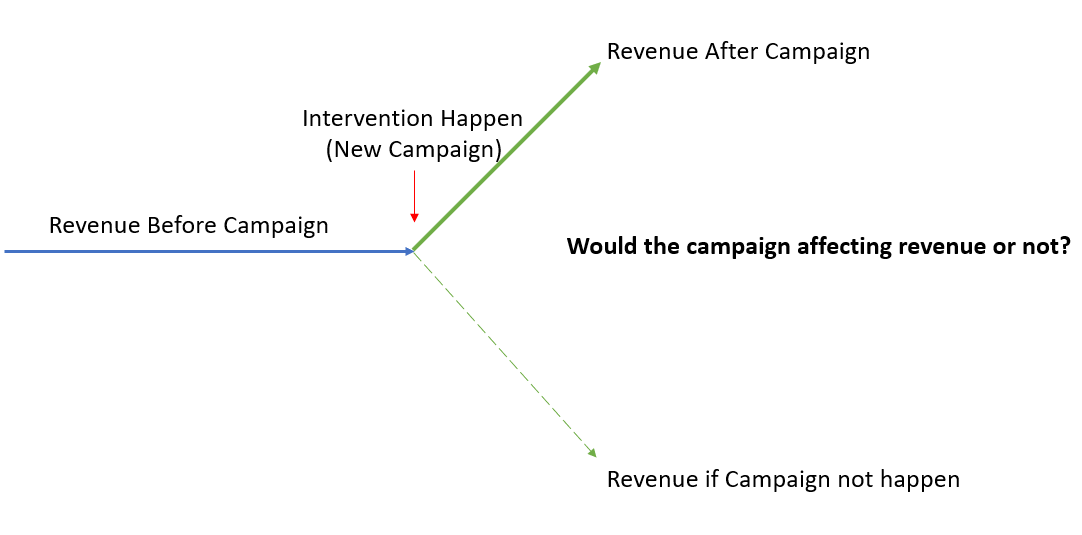

For this notebook we will be using the Python port: https://github.com/jamalsenouci/causalimpact

## We will now start with the practical use case by showing 2 examples

### Example 1
### COVID-19

In [ ]:
!pip install -q pycausalimpact
from causalimpact import CausalImpact

In [ ]:
import numpy as np
import pandas as pd
import os

from sklearn.metrics import mean_squared_error as mse

import matplotlib.pyplot as plt
import matplotlib.dates as md
%matplotlib inline


from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg

plt.style.use('fivethirtyeight')

In [ ]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

In [ ]:
# general settings
class CFG:
    img_dim1 = 10
    img_dim2 = 5
    tail = 20
    varlag = 4

# adjust the parameters for displayed figures
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})

In [ ]:
xdat = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')

In [ ]:
xdat['date'] = pd.to_datetime(xdat['date'])
# filter to Dutch data only
xdat = xdat.loc[xdat.iso_code == 'NLD']

<Axes: >

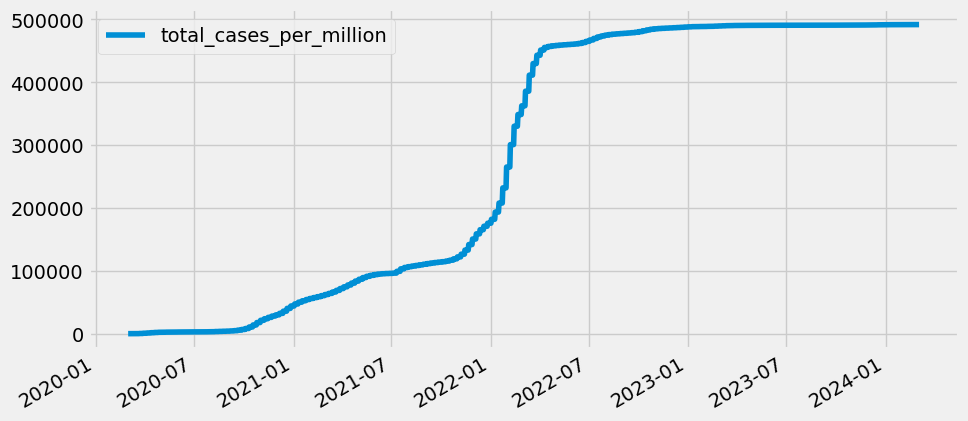

In [ ]:
# quick plot
xdat.set_index('date', inplace = True)
xdat[['total_cases_per_million']].plot(xlabel = '', figsize= (CFG.img_dim1, CFG.img_dim2))

In [ ]:
# when did vaccinations start => determine period limits
treatment_start = xdat['people_fully_vaccinated_per_hundred'].dropna().index[0]
raw_end = treatment_start - pd.Timedelta(days = 1)
raw_start = min(xdat.index)

treatment_end = max(xdat.index)

In [ ]:
pre_period  = [ raw_start , raw_end ]
post_period = [ treatment_start , treatment_end ]

ci = CausalImpact(xdat.loc[:,"total_cases_per_million"],  pre_period, post_period,
                  nseasons=[{'period': 12}], prior_level_sd=0.05)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: nseasons, standardize, prior_level_sd. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    354159.55          402679412.57
Prediction (s.d.)         52341.41 (13345.89)60140282.46 (15334432.93)
95% CI                    [26411.36, 78726.31][30346654.05, 90456526.57]

Absolute effect (s.d.)    301818.14 (13345.89)342539130.1 (15334432.93)
95% CI                    [275433.25, 327748.19][312222886.0, 372332758.51]

Relative effect (s.d.)    576.63% (25.5%)    569.57% (25.5%)
95% CI                    [526.22%, 626.17%] [519.16%, 619.11%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [ ]:
print(ci.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 354159.55. By contrast, in the absence of an
intervention, we would have expected an average response of 52341.41.
The 95% interval of this counterfactual prediction is [26411.36, 78726.31].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 301818.14 with a 95% interval of
[275433.25, 327748.19]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 402679412.57.
By contrast, had the intervention not taken place, we would have expected
a sum of 60140282.46. The 95% interval of this prediction is [30346654.05, 90456526.57].


The above results are given in terms of absolute n

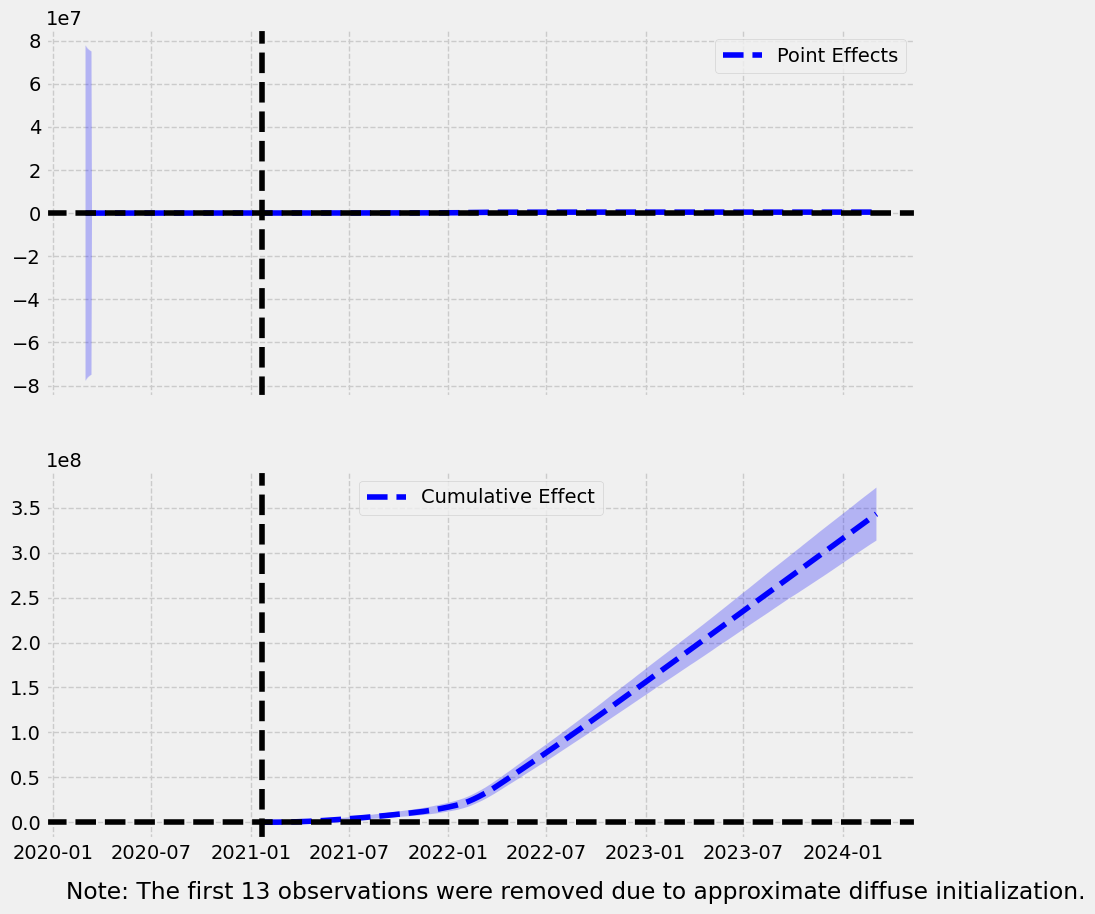

In [ ]:
# display the plots
ci.plot(panels=['pointwise','cumulative'], figsize= (10, 10))

**This example showed how to analyse the impact of a single intervention on a time series - so the next logical step is looking how two or more series can influence each other. Honoring a long-standing tradition in statistics, we start with a linear model for this.**

###Example 2:

#Granger causality

Establishing causality in observational data is notoriously difficult

Granger causality is a lower bar

Original idea: comparing the predictive power for a process  
Y
  using all the available information  
U
  with the same using  
U
∖
X

discarding X reduces the predictive power regarding Y  
⟹
  X contains some unique information regarding Y  
→
  X Granger-causes Y

in practice: if past (lagged) values of  
X
  improve prediction of  
Y
 , conditional on its own past values, then  
X
  Granger-causes  
Y

Granger’s causality test:  
H
0
  = coefficients of past values in the regression equation is zero  
→
  null is no causality

We will demonstrate Granger causality usefulness by predicting the price of evolution of major precious metals:

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/xpadyal/AdvanceDataScience_7390/main/commodity_prices.csv' ,
                  usecols = ['date','GOLD', 'PLATINUM', 'SILVER'])

In [ ]:
# process timestamp
df['date'] = pd.to_datetime(df['date'].apply(lambda s: s.replace('M', '-')))

df = df.set_index('date').rename_axis('metal', axis=1)

df.head()

metal,GOLD,PLATINUM,SILVER
date,,,
1960-01-01,35.27,83.5,0.91
1960-02-01,35.27,83.5,0.91
1960-03-01,35.27,83.5,0.91
1960-04-01,35.27,83.5,0.91
1960-05-01,35.27,83.5,0.91


In [ ]:
import plotly.express as px

fig = px.line(df, facet_col="metal", facet_col_wrap=1)
fig.update_yaxes(matches=None)
fig.show()

The figure above clearly suggests the series are not stationary - since it's a requirement for building a VAR model, let's test the idea

Augmented Dickey-Fuller is a popular choice

H
0
 : time series is not stationary  
→
  stationary around a trend

H
1
 : time series is stationary.

In [ ]:
def adf_test(df):
    result = adfuller(df.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

for f in df.columns:
    print('ADF Test: ' + str(f))
    adf_test(df[f])
    print('---')


ADF Test: GOLD
ADF Statistics: 0.302078
p-value: 0.977440
Critical values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
---
ADF Test: PLATINUM
ADF Statistics: -1.386696
p-value: 0.588637
Critical values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
---
ADF Test: SILVER
ADF Statistics: -2.066067
p-value: 0.258376
Critical values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
---


All p-values above any reasonable critical level  
⟹
  series are not stationary

Another approach: KPSS test

is the series stationary around a mean or linear trend, or is non-stationary due to a unit root.

H
0
: The time series is stationary

H
1
: The time series is not stationary

In [ ]:
from statsmodels.tsa.stattools import kpss

def kpss_test(df):
    statistic, p_value, n_lags, critical_values = kpss(df.values)

    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')

for f in ['GOLD', 'PLATINUM', 'SILVER']:
    print('KPSS Test: ' + str(f))
    kpss_test(df[f])
    print('---')

KPSS Test: GOLD
KPSS Statistic: 3.1595927383305833
p-value: 0.01
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
---
KPSS Test: PLATINUM
KPSS Statistic: 3.199494610358769
p-value: 0.01
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
---
KPSS Test: SILVER
KPSS Statistic: 2.405075459702326
p-value: 0.01
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
---


<ipython-input-33-8f960d2ecec4>:4: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


<ipython-input-33-8f960d2ecec4>:4: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


<ipython-input-33-8f960d2ecec4>:4: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [ ]:
# Transform and try again:

In [ ]:
df_transformed = df.copy()

for f in df.columns:
    df_transformed[f] = df[f].pct_change().fillna(0)

fig = px.line(df_transformed, facet_col="metal", facet_col_wrap=1)
fig.update_yaxes(matches=None)
fig.show()

In [ ]:
for f in df_transformed.columns:
    print('ADF Test: ' + str(f))
    adf_test(df_transformed[f])
    print('---')

ADF Test: GOLD
ADF Statistics: -5.750824
p-value: 0.000001
Critical values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
---
ADF Test: PLATINUM
ADF Statistics: -9.705005
p-value: 0.000000
Critical values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
---
ADF Test: SILVER
ADF Statistics: -14.634814
p-value: 0.000000
Critical values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
---


In [ ]:
for f in df_transformed.columns:
    print('KPSS Test: ' + str(f))
    kpss_test(df_transformed[f])
    print('---')

KPSS Test: GOLD
KPSS Statistic: 0.13475028705159106
p-value: 0.1
num lags: 7
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
---
KPSS Test: PLATINUM
KPSS Statistic: 0.08245174215299955
p-value: 0.1
num lags: 7
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
---
KPSS Test: SILVER
KPSS Statistic: 0.07523095832635517
p-value: 0.1
num lags: 6
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
---


<ipython-input-33-8f960d2ecec4>:4: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


<ipython-input-33-8f960d2ecec4>:4: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


<ipython-input-33-8f960d2ecec4>:4: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




One of the simplest ways to model a time series is to postulate a linear relationship between present and past values

X
t
=
θ
X
t
−
1
+
ϵ
t
  
(2)

VAR models are based on the simple idea: go multivariate by replacing the scalars (
X
t
  and  
θ
  being univariate) with vectors and matrices, respectively. The math behind a little bit more involved (linear algebra), but the core idea works equally well: for a  
k
 -dimensional series  
X
t
  we have

X
t
=
k
∑
i
=
1

A
i
X
t
−
k
+
ϵ
t
  
(3)

where  
A
i
  are  
k
x
k
  matrices and  
ϵ
t
∼
N
(
0
,
Σ
)
 .

Quick VAR summary:

generalize AR model to a multivariate case

prior knowledge: list of variables which can be hypothesized to affect each other over time

each variable has its own equation: lagged values of target and lagged values of other variables  
⟹
  AR(k) model. For a bivariate model:

X
1
,
t
=
A
1
,
1
X
1
,
t
−
1
+
A
1
,
2
X
2
,
t
−
1
+
ϵ
1
,
t
X
2
,
t
=
A
2
,
1
X
1
,
t
−
1
+
A
2
,
2
X
2
,
t
−
1
+
ϵ
2
,
t
  
(4)

bi-directional influence

baseline (VAR in level): all the series are stationary

With the theoretical setup out of the way, let's take VAR for a test drive.



In [ ]:
df_transformed.index = pd.DatetimeIndex(df_transformed.index).to_period('M')

In [ ]:
df_train, df_test = df_transformed[0:- CFG.tail], df_transformed[-CFG.tail:]

In [ ]:
# start with univariate models

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

for (ff, xcol) in enumerate(df_train.columns):

    model = AutoReg(df_train[xcol], lags = CFG.varlag).fit()
    pred = model.forecast(df_test.shape[0])
    xerr = my_rmse(df_test[xcol].values, pred)
    df_test[xcol + ' - single'] = pred.values
    print(xcol + ' RMSE: ' + str(xerr))

GOLD RMSE: 0.0301
PLATINUM RMSE: 0.0554
SILVER RMSE: 0.0569


**There are reasons to suspect that e.g. past performance of GOLD might help predict the future prices of silver - or perhaps vice versa? This is where formally testing for Granger causality comes in.**

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag = CFG.varlag
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_train, variables = df_train.columns)

,GOLD_x,PLATINUM_x,SILVER_x
GOLD_y,1.0000,0.0870,0.1670
PLATINUM_y,0.0016,1.0000,0.0096
SILVER_y,0.2217,0.3317,1.0000


So we now have decent reason to formulate a VAR model

In [ ]:
# fit a joint multivariate model
lag_order =  CFG.varlag
model1 = VAR(df_train)
results = model1.fit(maxlags= lag_order , ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 21, Mar, 2024
Time:                     18:48:41
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -18.3491
Nobs:                     728.000    HQIC:                  -18.5001
Log likelihood:           3708.61    FPE:                8.40056e-09
AIC:                     -18.5950    Det(Omega_mle):     7.96614e-09
--------------------------------------------------------------------
Results for equation GOLD
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.004693         0.001686            2.784           0.005
L1.GOLD             0.310467         0.054518            5.695           0.000
L1.PLATINUM        -0.061730         0.042538           -1.451       

In [ ]:
# predict from the joint model
joint_forecast = results.forecast(df_train.values[-4:], df_test.shape[0])

pd.options.mode.chained_assignment = None

for (ff,xcol) in enumerate(df_train.columns):
    df_test[xcol + ' - joint'] = joint_forecast[:,ff]

In [ ]:
# evaluate
for xc in df_train.columns:
    print(xc + ': ')
    xerr = my_rmse(df_test[xc], df_test[xc + ' - single'])
    print('single: ' + str(xerr))
    xerr = my_rmse(df_test[xc].values, df_test[xc + ' - joint'])
    print('joint: ' + str(xerr))
    print('---')

GOLD: 
single: 0.0301
joint: 0.0293
---
PLATINUM: 
single: 0.0554
joint: 0.0552
---
SILVER: 
single: 0.0569
joint: 0.0579
---


**As we can see from the metrics above, even incorporating single lag from the other variables can improve the quality of the forecast. - and Granger causality helps us decide if is makes sense**

Word to the wise: carelessly claiming causation causes confusion

Granger himself didn't like the term: "It is doubtful that philosophers would completely accept this definition, and possible cause is too strong a term, or not too emotionally laden, to be used."

A time series Granger-causes a second when it provides useful information about future values of a second series  
→
  temporal correlation (between time-shifted values)

co-movement / leading indicator

Granger-causality can be bidirectional  
⟹
  feedback mechanism between the two series

still useful for prediction!

References:
https://towardsdatascience.com/estimate-the-causal-effect-intervention-on-time-series-with-causalimpact-e949c5cd4147



#!! THANKYOU !!